In [1]:
import ipaddress
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score

train_dataset_path = 'dataset/Wednesday-workingHours.pcap_ISCX.csv'
test_dataset_path = 'dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'

train_data = pd.read_csv(train_dataset_path)
test_data = pd.read_csv(test_dataset_path)

In [2]:
def convert_ip2int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0  # Return 0 for invalid IP addresses    

def preprocess_data(data):
    df = data.copy()
    df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
    
    df['Source_IP'] = df['Source_IP'].apply(convert_ip2int)
    df['Destination_IP'] = df['Destination_IP'].apply(convert_ip2int)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce').astype(np.int64)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    y = np.where(df['Label'] == 'BENIGN', 0, 1)
    X = df.drop('Label', axis=1)
    X = X.select_dtypes(include=np.number)
    return X, y
# 위의 과정을 통해 Flow ID라는 int 형태가 될 수 없는 데이터와
# y로 분리되어 있는 Label을 제외한 나머지 데이터는 모두 숫자형으로 변환된다.

X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

print(f"Train 데이터 크기: {X_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}")
print("-" * 50)

Train 데이터 크기: (692703, 83)
Test 데이터 크기: (225745, 83)
--------------------------------------------------


In [3]:
print("## 1. 전체 Feature를 사용한 모델 학습 및 평가 ##")

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='f1',
    cv=3
)
grid_search.fit(X_train, y_train)

## 1. 전체 Feature를 사용한 모델 학습 및 평가 ##


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [50, 100]},
             scoring='f1')

In [4]:
print("최적의 하이퍼파라미터:", grid_search.best_params_)
model_full = grid_search.best_estimator_

y_pred_full = model_full.predict(X_test)
accuracy_full = accuracy_score(y_test, y_pred_full)
recall_full = recall_score(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full)

print(f"모델 정확도: {accuracy_full:.4f}")
print(f"재현율 (Recall): {recall_full:.4f}")
print(f"F1-Score: {f1_full:.4f}")
print("성능 리포트:")
print(classification_report(y_test, y_pred_full, target_names=['BENIGN (0)', 'ATTACK (1)']))
print("-" * 50)

최적의 하이퍼파라미터: {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}
모델 정확도: 0.7944
재현율 (Recall): 0.6374
F1-Score: 0.7786
성능 리포트:
              precision    recall  f1-score   support

  BENIGN (0)       0.68      1.00      0.81     97718
  ATTACK (1)       1.00      0.64      0.78    128027

    accuracy                           0.79    225745
   macro avg       0.84      0.82      0.79    225745
weighted avg       0.86      0.79      0.79    225745

--------------------------------------------------


In [5]:
print("## 2. Gini 중요도 기반 상위 10개 특성 추출 ##")
importances = model_full.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)
top_10_feature_names = feature_importances.head(10)['feature'].tolist()

print("상위 10개 특성:")
print(feature_importances.head(10))
print("-" * 50)

## 2. Gini 중요도 기반 상위 10개 특성 추출 ##
상위 10개 특성:
                   feature  importance
0                Source_IP    0.134976
5                Timestamp    0.064262
59    Avg_Bwd_Segment_Size    0.060298
17  Bwd_Packet_Length_Mean    0.059858
18   Bwd_Packet_Length_Std    0.054108
3         Destination_Port    0.042835
47  Packet_Length_Variance    0.042066
45      Packet_Length_Mean    0.038445
57     Average_Packet_Size    0.032996
42           Bwd_Packets_s    0.031473
--------------------------------------------------


In [6]:
print("## 3. 상위 6개 특성만 사용한 모델 학습 및 평가 ##")
X_train_top6 = X_train[top_10_feature_names[:6]]
X_test_top6 = X_test[top_10_feature_names[:6]]

grid_search_top6 = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='f1',
    cv=3
)
grid_search_top6.fit(X_train_top6, y_train)

print("최적의 하이퍼파라미터 (상위 6개 특성):", grid_search_top6.best_params_)
model_top6 = grid_search_top6.best_estimator_

y_pred_top6 = model_top6.predict(X_test_top6)
accuracy_top6 = accuracy_score(y_test, y_pred_top6)
recall_top6 = recall_score(y_test, y_pred_top6)
f1_top6 = f1_score(y_test, y_pred_top6)

print(f"모델 정확도: {accuracy_top6:.4f}")
print(f"재현율 (Recall): {recall_top6:.4f}")
print(f"F1-Score: {f1_top6:.4f}")
print("성능 리포트:")
print(classification_report(y_test, y_pred_top6, target_names=['BENIGN (0)', 'ATTACK (1)']))

print("-" * 50)

## 3. 상위 6개 특성만 사용한 모델 학습 및 평가 ##
최적의 하이퍼파라미터 (상위 6개 특성): {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 50}
모델 정확도: 1.0000
재현율 (Recall): 1.0000
F1-Score: 1.0000
성능 리포트:
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00     97718
  ATTACK (1)       1.00      1.00      1.00    128027

    accuracy                           1.00    225745
   macro avg       1.00      1.00      1.00    225745
weighted avg       1.00      1.00      1.00    225745

--------------------------------------------------


In [7]:

print("## 4. RFECV 기반 최적의 특성 개수 및 목록 추출 ##")

cv_strategy = StratifiedKFold(n_splits=3)

rfecv = RFECV(
    estimator=model_full,
    step=2,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rfecv.fit(X_train, y_train)


## 4. RFECV 기반 최적의 특성 개수 및 목록 추출 ##
Fitting estimator with 83 features.
Fitting estimator with 81 features.
Fitting estimator with 79 features.
Fitting estimator with 77 features.
Fitting estimator with 75 features.
Fitting estimator with 73 features.
Fitting estimator with 71 features.
Fitting estimator with 69 features.


RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(min_samples_leaf=5, n_jobs=-1,
                                       random_state=42),
      n_jobs=-1, scoring='f1', step=2, verbose=1)

In [8]:
best_features = X_train.columns[rfecv.support_]
print(f"\n최적의 특성 개수: {rfecv.n_features_}")
print("선택된 특성 목록:", best_features.tolist())
print("-" * 50)


최적의 특성 개수: 67
선택된 특성 목록: ['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol', 'Timestamp', 'Flow_Duration', 'Total_Fwd_Packets', 'Total_Backward_Packets', 'Total_Length_of_Fwd_Packets', 'Total_Length_of_Bwd_Packets', 'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean', 'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Max', 'Bwd_Packet_Length_Min', 'Bwd_Packet_Length_Mean', 'Bwd_Packet_Length_Std', 'Flow_Bytes_s', 'Flow_Packets_s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_Header_Length', 'Bwd_Header_Length', 'Fwd_Packets_s', 'Bwd_Packets_s', 'Min_Packet_Length', 'Max_Packet_Length', 'Packet_Length_Mean', 'Packet_Length_Std', 'Packet_Length_Variance', 'FIN_Flag_Count', 'PSH_Flag_Count', 'ACK_Flag_Count', 'URG_Flag_Count', 'Down_Up_Ratio', 'Average_Packet_Size', 'Avg_Fwd_Segment_

In [9]:
print("## 5. 최적의 특성을 사용한 모델 학습 및 평가 ##")

X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

grid_search_best = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='f1',
    cv=3 # 또는 cv_strategy
)
grid_search_best.fit(X_train_best, y_train)

print("최적의 하이퍼파라미터 (최적 특성):", grid_search_best.best_params_)
model_best = grid_search_best.best_estimator_

y_pred_best = model_best.predict(X_test_best)
accuracy_best = accuracy_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print(f"모델 정확도: {accuracy_best:.4f}")
print(f"재현율 (Recall): {recall_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")
print("성능 리포트:")
print(classification_report(y_test, y_pred_best, target_names=['BENIGN (0)', 'ATTACK (1)']))
print("-" * 50)

## 5. 최적의 특성을 사용한 모델 학습 및 평가 ##
최적의 하이퍼파라미터 (최적 특성): {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 50}
모델 정확도: 0.9768
재현율 (Recall): 0.9591
F1-Score: 0.9791
성능 리포트:
              precision    recall  f1-score   support

  BENIGN (0)       0.95      1.00      0.97     97718
  ATTACK (1)       1.00      0.96      0.98    128027

    accuracy                           0.98    225745
   macro avg       0.97      0.98      0.98    225745
weighted avg       0.98      0.98      0.98    225745

--------------------------------------------------


In [10]:
print("## 6. 최적의 하이퍼파라미터로 재학습 및 시간 측정 ##")
import time

start_time = time.time()
best_full = grid_search.best_estimator_
best_full.fit(X_train, y_train)
end_time = time.time()
print(f"전체 특성으로 재학습 시간: {end_time - start_time:.4f}초")

start_time_top6 = time.time()
best_top6 = grid_search_top6.best_estimator_
best_top6.fit(X_train_top6, y_train)
end_time_top6 = time.time()
print(f"상위 6개 특성으로 재학습 시간: {end_time_top6 - start_time_top6:.4f}초")

start_time_best = time.time()
best_model = model_best
best_model.fit(X_train_best, y_train)
end_time_best = time.time()
print(f"최적의 특성으로 재학습 시간: {end_time_best - start_time_best:.4f}초")

print("-" * 50)

## 6. 최적의 하이퍼파라미터로 재학습 및 시간 측정 ##
전체 특성으로 재학습 시간: 16.7561초
상위 6개 특성으로 재학습 시간: 1.5949초
최적의 특성으로 재학습 시간: 8.6502초
--------------------------------------------------


In [11]:
print("## 7. 최종 성능 비교 ##")
print("[전체 특성 사용 모델]")
print(f" - 하이퍼파라미터: {grid_search.best_params_}")
print(f" - 정확도 (Accuracy): {accuracy_full:.4f}")
print(f" - 재현율 (Recall): {recall_full:.4f}")
print(f" - F1-Score: {f1_full:.4f}")
print(f" - 학습 시간: {end_time - start_time:.4f}초")

print("[상위 6개 특성 사용 모델]")
print(f" - 하이퍼파라미터: {grid_search_top6.best_params_}")
print(f" - 정확도 (Accuracy): {accuracy_top6:.4f}")
print(f" - 재현율 (Recall): {recall_top6:.4f}")
print(f" - F1-Score: {f1_top6:.4f}")
print(f" - 학습 시간: {end_time_top6 - start_time_top6:.4f}초")

print("[최적의 특성 사용 모델]")
print(f" - 하이퍼파라미터: {grid_search_best.best_params_}")
print(f" - 정확도 (Accuracy): {accuracy_best:.4f}")
print(f" - 재현율 (Recall): {recall_best:.4f}")
print(f" - F1-Score: {f1_best:.4f}")
print(f" - 학습 시간: {end_time_best - start_time_best:.4f}초")

print("-" * 50)

## 7. 최종 성능 비교 ##
[전체 특성 사용 모델]
 - 하이퍼파라미터: {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}
 - 정확도 (Accuracy): 0.7944
 - 재현율 (Recall): 0.6374
 - F1-Score: 0.7786
 - 학습 시간: 16.7561초
[상위 6개 특성 사용 모델]
 - 하이퍼파라미터: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 50}
 - 정확도 (Accuracy): 1.0000
 - 재현율 (Recall): 1.0000
 - F1-Score: 1.0000
 - 학습 시간: 1.5949초
[최적의 특성 사용 모델]
 - 하이퍼파라미터: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 50}
 - 정확도 (Accuracy): 0.9768
 - 재현율 (Recall): 0.9591
 - F1-Score: 0.9791
 - 학습 시간: 8.6502초
--------------------------------------------------


## 8. ROC curve 및 AUC ##


Text(0.5, 1.0, 'ROC Curve')

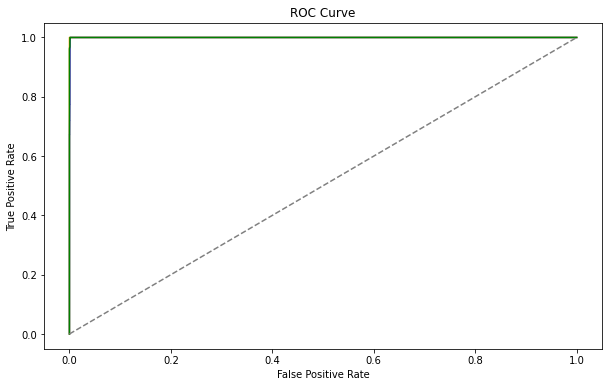

In [12]:
print("## 8. ROC curve 및 AUC ##")
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

y_scores_full = model_full.predict_proba(X_test)[:, 1]
y_scores_top6 = model_top6.predict_proba(X_test_top6)[:, 1]
y_scores_best = best_model.predict_proba(X_test_best)[:, 1]

fpr_full, tpr_full, _ = roc_curve(y_test, y_scores_full)
fpr_top6, tpr_top6, _ = roc_curve(y_test, y_scores_top6)
fpr_best, tpr_best, _ = roc_curve(y_test, y_scores_best)
roc_auc_full = auc(fpr_full, tpr_full)
roc_auc_top6 = auc(fpr_top6, tpr_top6)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(10, 6))
plt.plot(fpr_full, tpr_full, color='blue', label=f'전체 특성 (AUC = {roc_auc_full:.2f})')
plt.plot(fpr_top6, tpr_top6, color='orange', label=f'상위 6개 특성 (AUC = {roc_auc_top6:.2f})')
plt.plot(fpr_best, tpr_best, color='green', label=f'최적의 특성 (AUC = {roc_auc_best:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')

In [13]:
## 모델 저장
import joblib
import os

print("## 전체 특성 모델 저장")
save_path_full = 'models/rf_model_full.pkl'
os.makedirs(os.path.dirname(save_path_full), exist_ok=True)
joblib.dump(model_full, save_path_full)

print("## 상위 6개 특성 모델 저장")
save_path_top6 = 'models/rf_model_top6.pkl'
os.makedirs(os.path.dirname(save_path_top6), exist_ok=True)
joblib.dump(model_top6, save_path_top6)

print("## 최적의 특성 모델 저장")
save_path_best = 'models/rf_model_best.pkl'
os.makedirs(os.path.dirname(save_path_best), exist_ok=True)
joblib.dump(best_model, save_path_best)

file_top6_features = 'models/top6_features.txt'
with open(file_top6_features, 'w') as f:
    for features in top_10_feature_names[:6]:
        f.write(f"{features}\n")

file_best_features = 'models/best_features.txt'
with open(file_best_features, 'w') as f:
    for features in best_features:
        f.write(f"{features}\n")

print("저장이 완료되었습니다.")

## 전체 특성 모델 저장
## 상위 6개 특성 모델 저장
## 최적의 특성 모델 저장
저장이 완료되었습니다.
